# Deep Neural Texture in Keras

This is the reproduced version of ["Texture Synthesis using Convolutional Neural Networks" [Gatys et al., NIPS15]](https://github.com/leongatys/DeepTextures). Although the authors provided their code in public, but their code needs old [caffe framework](https://github.com/BVLC/caffe) which is not so handy to install. Instead of using caffe, we reproduce the same functionality with [Keras framework](https://github.com/keras-team/keras/).

## 1. Preparation

First, we load the reference image and pretrained VGG19 network.  
The weights are *normalized* version for the better performance. This weights can be found from Bethge lab's webpage. Since it is caffe's weight file (**.caffemodel**), we convert it keras's format (**.h5**) by using [caffe2keras](https://github.com/qxcv/caffe2keras).

In [1]:
import numpy as np
import cv2 ## load image in BGR
import matplotlib.pyplot as plt ## image visualization in jupyter notebook

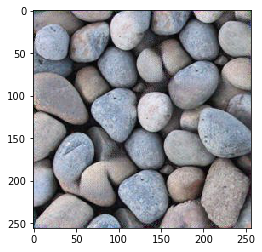

In [2]:
###############################################################################
## load reference image
###############################################################################
img_ref_cv2 = cv2.imread('data/pebbles.jpg')
H, W, _ = img_ref_cv2.shape

plt.imshow(img_ref_cv2[...,::-1]) ## BGR->RGB
plt.show()

In [3]:
###############################################################################
## define input tensor & load normalized VGG19 network
###############################################################################
from stNoh import vgg19
from keras import backend as K

## Define input tensor size, same with reference image
data_format = K.image_data_format()
input_tensor = (1,H,W,3) if data_format=='channels_last' else (1,3,H,W)
dst_img = K.placeholder(shape=input_tensor)

## Load pretrained normalized-VGG19
model_notop = vgg19.VGG19(input_tensor=dst_img, avgPooling=True)
#model_notop.summary() ## visualize 

## Get all layer information
outputs_dict = dict([(layer.name, layer.output) for layer in model_notop.layers])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


## 2. Loss Function

Next, we define the loss function.  
Layers and its weights are same with the paper in [Gatys15]. We compute the gram matrices of reference image in advance, and define the loss function of synthesized image by the difference of gram matrices in each layer. In computation of gradients, we can simply rely on the **automatic differentiation** in keras framework (and actually there is no alternative since keras *does not support* **backward propagation** as default).

In [4]:
## Same layers & weights with [Gatys15]
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
weight_layers  = [1e9, 1e9, 1e9, 1e9, 1e9]

## Get the featuremaps from intermediate layers
func_layers = K.function([model_notop.input],
                         [model_notop.get_layer(layer).output[0,:,:,:] for layer in feature_layers])

In [5]:
###############################################################################
## defined gram matrix in numpy
###############################################################################
def get_np_gram_matrices(img_keras):
    outputs = func_layers([img_keras])
    
    G = []
    for l, layer_name in enumerate(feature_layers):
        G_l = vgg19.np_gram_matrix(outputs[l])
        G.append(G_l)
    return G

## Get Gram matrix of the reference image (never changed until optimization)
img_ref_keras = vgg19.preprocess_input(img_ref_cv2)
G_ref = get_np_gram_matrices(img_ref_keras)

###############################################################################
## define Loss function and its gradient
###############################################################################
loss  = K.variable(0.)

for l, layer_name in enumerate(feature_layers):
    layer_features = outputs_dict[layer_name]
    F_dst_l = layer_features[0, :, :, :]

    # Getting loss per layer
    G_dst_l = vgg19.keras_gram_matrix(F_dst_l)
    layer_loss = K.sum(K.square(G_ref[l] - G_dst_l))
    
    # Calculating total loss
    loss  = loss + layer_loss * weight_layers[l]
    
## Compute gradients by keras' auto-diff
grads = K.gradients(loss, dst_img)
    
## Concatenate loss and gradients
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

## Wrapping the process above as a single function.
f_outputs = K.function([dst_img], outputs)

In [6]:
###############################################################################
## interface between scipy (1D vector) and keras (4D tensor)
###############################################################################
def eval_loss_and_grads(x):

    # Reshaping 1D input vector as 4D keras tensor
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, H, W))
    else:
        x = x.reshape((1, H, W, 3))

    # Separating loss and gradients from output
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    
    return loss_value, grad_values

## 3. Texture Synthesis by Optimization

Last, we obtain new synthesized image by optimization.  
The synthesized image is started from the randomly initialized pixels, and converged to similar-looking image by minimization. To track the iteration, we visualize the progress images in the optimization.

In [7]:
###############################################################################
## convert synthesized image as integer image
###############################################################################
def deprocess_input(x):
    
    ## Checking the data format supported by the backend
    if K.image_data_format() == 'channels_first':
        x = x.reshape(3, H, W)
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape(H, W, 3)
    
    ## Remove zero-center by mean pixel
    x[:,:,0] += vgg19.imagenet_mean[0]
    x[:,:,1] += vgg19.imagenet_mean[1]
    x[:,:,2] += vgg19.imagenet_mean[2]

    ## convert from float [0.0:255.0] to integer [0,255]
    img_cv2_uint = np.clip(x, 0, 255).astype('uint8')
    
    return img_cv2_uint

## show synthesized image
def ShowImage(x):
    img_dst_cv2 = deprocess_input(x)
    plt.imshow(img_dst_cv2[...,::-1]) ## BGR->RGB
    plt.show()
    return None


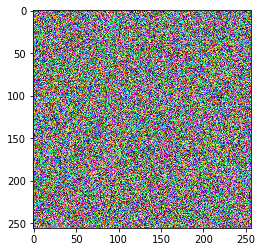

iter: 0, Loss = 130211616.0


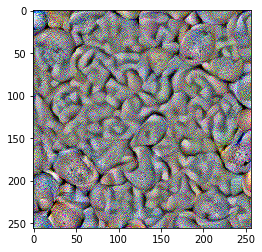

iter: 1, Loss = 36571004.0


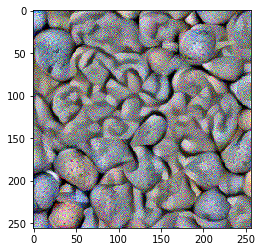

iter: 2, Loss = 19537588.0


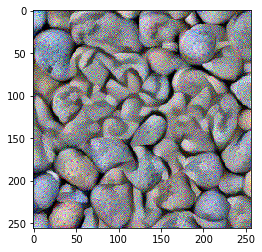

iter: 3, Loss = 13876039.0


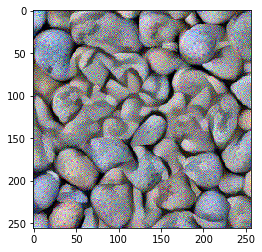

iter: 4, Loss = 11087494.0


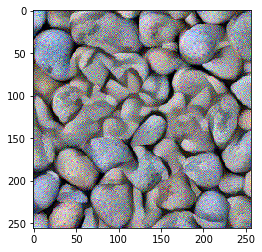

iter: 5, Loss = 9519279.0


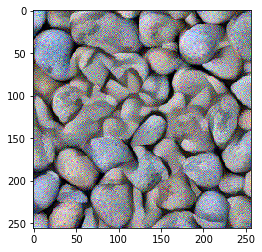

iter: 6, Loss = 8422990.0


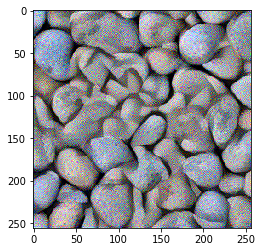

iter: 7, Loss = 7644149.5


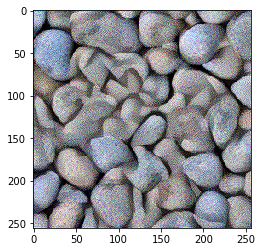

iter: 8, Loss = 6992788.5


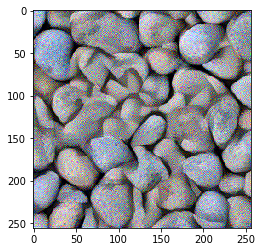

iter: 9, Loss = 6576138.0


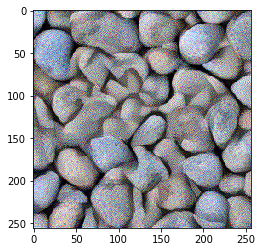

In [8]:
max_iter = 10

## initialize random image
img_dst_cv2 = 255.0 * np.random.rand(H, W, 3)
x = vgg19.preprocess_input(img_dst_cv2).flatten()

## set optimization boundary
B_bound = (-vgg19.imagenet_mean[0], 255.0-vgg19.imagenet_mean[0])
G_bound = (-vgg19.imagenet_mean[1], 255.0-vgg19.imagenet_mean[1])
R_bound = (-vgg19.imagenet_mean[2], 255.0-vgg19.imagenet_mean[2])

if K.image_data_format() == 'channels_first':
    bounds = []
    bounds += [B_bound] * W * H
    bounds += [G_bound] * W * H
    bounds += [R_bound] * W * H
else:
    bounds = [B_bound, G_bound, R_bound] * W * H
    
###############################################################################
## L-BFGS optimization
###############################################################################
from scipy.optimize import minimize

ShowImage(x.copy())

for i in range(max_iter):
    print("iter: {} ...".format(i), end='\r')
    
    opt = minimize(eval_loss_and_grads, x.flatten(),
                      method='L-BFGS-B',
                      jac=True,
                      bounds=bounds,
                      options={'maxiter':20}
                  )
    x = opt.x
    
    print("iter: {}, Loss = {}".format(i, opt.fun))
    
    ShowImage(x.copy())
